### Installing packages ###

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.subplots import make_subplots

import survivalnet2
from survivalnet2.data.labels import stack_labels, unstack_labels
from survivalnet2.losses import efron, cox
from survivalnet2.metrics.concordance import HarrellsC
from survivalnet2.visualization import km_plot

# Set random seeds for reproducibility
np.random.seed(51)
tf.random.set_seed(51)

### Data preprocessing ###

In [2]:
def binarize_first_column(df):
    # binarizr region identifier as 0 or 1
    df[df.columns[0]] = df.iloc[:, 0].apply(lambda x: 1 if x == 'TUMOR' else 0)
    return df


def compute_median_values(data_files):
    # Read in first file to get the columns
    sample = pd.read_csv(data_files[0])
    num_cols = sample.shape[1] - 2  # Exclude the first two columns

    # Initialize array to store values for all files
    values = np.empty((0, num_cols))

    # Iterate over all files and extract values
    for data_file in data_files:
        # Read in data and skip first row (assumed to be header)
        df = pd.read_csv(data_file, skiprows=[0], usecols=range(2, num_cols+2))
        df = binarize_first_column(df)
        values = np.concatenate((values, df.values), axis=0)
    
    # Compute median values for each column
    median_values = np.median(values, axis=0)
    median_dict = {sample.columns[i+2]: median_values[i] for i in range(num_cols)}
    return median_dict


def pad_missing_values(df, median_dict):
    # Replace missing values with median value for each column
    for col in df.columns:
        median_value = median_dict[col]
        df[col].fillna(median_value, inplace=True)
    return df


def min_max_normalize_features(df):

    for col in df.columns:
        min_value = df[col].min()
        max_value = df[col].max()
        
        # Check if values are not already in the range [0, 1]
        if (min_value < 0 or max_value > 1):
            df[col] = (df[col] - min_value) / (max_value - min_value)
        
    return df


def z_score_normalize_ragged_tensor(ragged_tensor):
    scaler = StandardScaler()

    # Store the lengths of the subtensors before flattening the ragged tensor
    lengths = [len(subtensor) for subtensor in ragged_tensor]

    # Flatten the ragged tensor and convert it to a 2D numpy array
    flat_data = ragged_tensor.to_tensor().numpy().reshape(-1, 49)

    # Fit and transform the data using the StandardScaler
    normalized_data = scaler.fit_transform(flat_data)

    # Check if mean is close to 0 and standard deviation is close to 1
    mean = np.mean(normalized_data, axis=0)
    std_dev = np.std(normalized_data, axis=0)

    print("Mean:", mean)
    print("Standard Deviation:", std_dev)
    
    # Restore the original ragged structure
    normalized_data_ragged = []
    start_idx = 0
    for length in lengths:
        normalized_data_ragged.append(normalized_data[start_idx:start_idx+length])
        start_idx += length

    return tf.ragged.constant(normalized_data_ragged, ragged_rank=1, dtype=tf.float32)


def create_label_dict(label_dir):
    df = pd.read_csv(label_dir)
    column_names = df.columns  # Get the column names from the first row
    label_dict = {}
    for i in range(1, len(df)):
        name = df.iloc[i, 0]  # Get the sample name from the first column of the current row
        erstat = df.iloc[i, column_names.get_loc('ClinicalFeats.IHCMarker.erstat')]
        prstat = df.iloc[i, column_names.get_loc('ClinicalFeats.IHCMarker.prstat')]
        her2stat = df.iloc[i, column_names.get_loc('ClinicalFeats.IHCMarker.her2stat')]
        if erstat in ['positive', 'negative'] and prstat in ['positive', 'negative'] and her2stat in ['positive', 'negative']:
            time = df.iloc[i, column_names.get_loc('ClinicalFeats.Survival.BCSS.YearsFromDx')]  # Get the time data from the 'ClinicalFeats.Survival.BCSS.YearsFromDx' column
            event = df.iloc[i, column_names.get_loc('ClinicalFeats.Survival.BCSS')]  # Get the event data from the 'ClinicalFeats.Survival.BCSS' column
            globals_erstat = df.iloc[i, column_names.get_loc('ClinicalFeats.IHCMarker.erstat')]
            globals_prstat = df.iloc[i, column_names.get_loc('ClinicalFeats.IHCMarker.prstat')]
            globals_her2stat = df.iloc[i, column_names.get_loc('ClinicalFeats.IHCMarker.her2stat')]
            label_dict[name] = {
                'label': (time, event),
                'globals': (globals_erstat, globals_prstat, globals_her2stat)
            }
    return label_dict


### Parameters definition ###

In [3]:
# define dimensionality
D = 49
G = 3
print(f"Dimensionality of each feature vector is: {D}")
print(f"number of global features we use is: {G}")
# Define the batch size you want to use
batch_size = 64


data_dir = '/Users/shangke/Desktop/pathology/raw_data/perSlideRegionFeatures/CPSII_40X'
label_dir = '/Users/shangke/Desktop/pathology/raw_data/perSlideRegionFeatures/FusedData_CPSII_40X.csv'
csv_names = os.listdir(data_dir)
null_count = 0
label_dict = create_label_dict(label_dir)
valid_csv_names = []

for name in csv_names:
    if name.rstrip('.csv') in list(label_dict.keys()):
        valid_csv_names.append(name)

    else:
        null_count += 1
        
# Shuffle the list of valid CSV names
random.shuffle(valid_csv_names)

data_files = [os.path.join(data_dir, str(csv_name)) for csv_name in valid_csv_names]

print(f"Number of samples with missing label or globals: {null_count}")


Dimensionality of each feature vector is: 49
number of global features we use is: 3
Number of samples with missing label or globals: 390


### Generate dataset ###

In [4]:
def read_data(data_files, label_dict):
    """
    Reads in the data files, binarizes the columns, pads missing values, and normalizes the features.

    Args:
        data_files (list): List of file paths to the data files.
        label_dict (dict): Dictionary mapping file names to (time, event) tuples.

    Returns:
        A tuple containing:
            - rows_tensor (tf.RaggedTensor): A ragged tensor containing the feature vectors for each sample.
            - labels_tensor (tuple): A tuple of two tensors, containing the time and event labels for each sample.
    """
    rows_list = []
    globals_list = []
    time_list = []
    event_list = []
    empty_count = 0

    # Calculate median values for each feature across all data files
    median_values = compute_median_values(data_files)

    for data_file in data_files:
        # Get the name of the file without the extension
        name = os.path.splitext(os.path.basename(data_file))[0]

        # Skip the file if it is not in the label dictionary
        if name not in label_dict:
            empty_count += 1
            continue

        # Read in the data file
        df = pd.read_csv(data_file)
        

        # Skip the file if it has no rows
        if df.shape[0] < 1:
            empty_count += 1
            print(name)
            continue

        # Binarize the columns and pad missing values
        df = df.iloc[:, 2:]  # Drop the first two columns
        df = binarize_first_column(df)
        df = pad_missing_values(df, median_values)
        # Add the feature vector and labels to the lists
        rows_list.append(df.values)

        # Normalize the features
        # df = min_max_normalize_features(df)
    
        # Get the label and globals for the current file
        time, event = label_dict[name]['label']
        globals = label_dict[name]['globals']
        globals = [1 if g == 'positive' else 0 for g in globals]
        globals_list.append(globals)
        time_list.append(time)
        event_list.append(event)
    
    # Convert the lists to tensors
    rows_tensor = tf.ragged.constant(rows_list, ragged_rank=1, dtype=tf.float32)
    globals_tensor = tf.convert_to_tensor(globals_list, dtype=tf.float32)
    labels_tensor = stack_labels(tf.convert_to_tensor(time_list, dtype=tf.float32),
                                 tf.convert_to_tensor(event_list, dtype=tf.float32))
    
    print(f"Number of samples: {len(rows_list)}")
    print(f"Number of empty data files: {empty_count}")

    return rows_tensor, labels_tensor, globals_tensor

data, labels, globals = read_data(data_files, label_dict)

data = z_score_normalize_ragged_tensor(data)
print(data.shape)
print(labels.shape)
print(globals.shape)

2023-07-27 20:47:17.314508: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of samples: 1318
Number of empty data files: 0
Mean: [ 2.43653631e-05 -6.72185570e-06 -7.60950070e-06  5.60891312e-05
 -2.45372098e-06  2.99012390e-06 -2.30162768e-05 -6.27544159e-06
  2.23031157e-06 -1.36333092e-05 -3.70816306e-05 -3.73653893e-06
 -9.63283219e-06  2.48641118e-05  4.22359772e-05  4.62000498e-05
 -1.11170535e-04 -3.51214840e-05 -2.47726143e-06  5.45609009e-06
  1.99741407e-05 -6.52433519e-05  6.86149770e-06 -1.24637234e-06
 -3.10828145e-05 -1.39447302e-05 -6.93677794e-05  5.08758058e-06
 -9.95049850e-05 -2.97517681e-06  2.65101471e-06  3.15128477e-06
 -2.74411686e-05  1.81296600e-05  7.77048481e-05  2.74666691e-05
 -2.91260881e-06 -5.68923533e-05  8.36038362e-06  1.29647262e-04
 -1.16787387e-05 -1.09325483e-05  1.24944549e-04 -3.51632261e-05
 -5.38835338e-05 -3.02797635e-05  2.19149024e-05 -1.16818970e-04
  3.45688786e-05]
Standard Deviation: [1.007064   0.999321   0.9993554  1.0046407  0.9918148  0.99910575
 1.0050439  0.9916159  0.9994029  0.9918983  0.99413574

### Remove subjects with persistent NaNs ###

Some NaNs may remain for subjects (10 samples) that have a single region that also contains NaN features (median imputation doesn't work in this case).

In [5]:
indices = []
for i, subject in enumerate(data):
    if not np.sum(np.isnan(subject)):
        indices.append(i)
data_with_globals = tf.gather(data, np.array(indices), axis=0)
labels = tf.gather(labels, np.array(indices), axis=0)

### Data visualization (Optional, results are too long!!!) ###

Visualize the distribution of each features and also a distrubution of the number of time & event labels.

In [ ]:
def visualize_data_distribution(data, labels):
    # Flatten the data and create a DataFrame
    flattened_data = data.flat_values.numpy()
    data_df = pd.DataFrame(flattened_data)
    
    # Visualize the distribution of each feature
    n_features = data_df.shape[1]
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 4 * n_features))

    for i in range(n_features):
        sns.kdeplot(data_df.iloc[:, i], ax=axes[i])
        axes[i].set_title(f"Feature {i+1} Distribution")
        axes[i].set_xlabel(f"Feature {i+1}")
        axes[i].set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    # Visualize the distribution of labels
    labels_df = pd.DataFrame(labels.numpy(), columns=["Time", "Event"])
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(labels_df["Time"], kde=True, ax=axes[0], bins=50)
    axes[0].set_title("Time Distribution")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Frequency")

    sns.histplot(labels_df["Event"], discrete=True, ax=axes[1], binwidth=1)
    axes[1].set_title("Event Distribution")
    axes[1].set_xlabel("Event")
    axes[1].set_ylabel("Frequency")
    axes[1].set_xticks([0, 1])

    plt.tight_layout()
    plt.show()

visualize_data_distribution(data, labels)

### Model Definition ###

In [6]:
def build_model_att(D, G, num_attention_layers=2):
    # Local and global inputs
    inputs_local = tf.keras.layers.Input(shape=(None, D), ragged=True)
    inputs_global = tf.keras.layers.Input(shape=(G,), dtype=tf.float32)

    # Process local inputs with multiple dense layers and dropout
    att = inputs_local
    for _ in range(num_attention_layers):
        att = tf.keras.layers.Dense(units=49, activation="relu")(att)


    # Attention weights
    att = tf.keras.layers.Dense(units=1, activation="relu", name="att")(att)

    # Normalize weights to sum to 1
    totals = tf.reduce_sum(att, axis=1, name="att_total")
    normalized = tf.math.divide_no_nan(att, tf.expand_dims(totals, axis=1), name="normalized")

    # Use attention weights to calculate weighted sum of regions
    pooled = tf.linalg.matmul(normalized, inputs_local, transpose_a=True)

    # Remove the ragged dimension and reshape pooled tensor
    pooled = tf.squeeze(pooled.to_tensor(), axis=1)

    # Concatenate the pooled vector and global inputs
    concat = tf.keras.layers.Concatenate()([pooled, inputs_global])

    # Apply a linear layer to the concatenated vector to generate the risk values
    risk = tf.keras.layers.Dense(units=1, activation="linear", name="risk")(concat)

    # Build the model
    model = tf.keras.models.Model(inputs=[inputs_local, inputs_global], outputs=risk)

    print(f"The input shape of model is: {model.input_shape}")
    print(f"The output shape of model is: {model.output_shape}")

    return model





def build_model_avg(D, G):
    # Local and global inputs
    inputs_local = tf.keras.layers.Input(shape=(None, D), ragged=True)
    inputs_global = tf.keras.layers.Input(shape=(G,), dtype=tf.float32)

    # Average feature vectors along the ragged dimension
    averaged = tf.reduce_mean(inputs_local, axis=1)

    # Concatenate the averaged vector and global inputs
    concat = tf.keras.layers.Concatenate()([averaged, inputs_global])

    # Apply a linear layer to the concatenated vector to generate the risk values
    risk = tf.keras.layers.Dense(units=1, activation="linear", name="risk")(concat)

    # Build the model
    model = tf.keras.models.Model(inputs=[inputs_local, inputs_global], outputs=risk)

    print(f"The input shape of model is: {model.input_shape}")
    print(f"The output shape of model is: {model.output_shape}")

    return model


def build_model_att_NAM(D, G, config):
    def _build_dense_layer(units, activation):
        return tf.keras.layers.Dense(units=units, activation=activation)

    # Local and global inputs
    inputs_local = tf.keras.layers.Input(shape=(None, D), ragged=True)
    inputs_global = tf.keras.layers.Input(shape=(G,), dtype=tf.float32)

    # Attention weights
    att = tf.keras.layers.Dense(units=1, activation="relu", name="att")(inputs_local)

    # Normalize weights to sum to 1
    totals = tf.reduce_sum(att, axis=1, name="att_total")
    normalized = tf.math.divide_no_nan(att, tf.expand_dims(totals, axis=1), name="normalized")

    # Use attention weights to calculate weighted sum of regions
    pooled = tf.linalg.matmul(normalized, inputs_local, transpose_a=True)

    # Remove the ragged dimension and reshape pooled tensor
    pooled = tf.squeeze(pooled.to_tensor(), axis=1)

    # Concatenate the pooled vector and global inputs
    concat = tf.keras.layers.Concatenate()([pooled, inputs_global])

    # Build NAM for each feature
    all_models = []
    for i in range(concat.shape[1]):
        each_input = tf.keras.layers.Lambda(lambda x: x[:, i:i+1])(concat) # extracting each feature separately
        dense = []
        for u, a in zip(config["units"], config["activation"]):
            if not dense:
                dense.append(_build_dense_layer(u, a)(each_input))
            else:
                dense.append(_build_dense_layer(u, a)(dense[-1]))        
        all_models.append(tf.keras.Model(inputs=[inputs_local, inputs_global], outputs=_build_dense_layer(1,"linear")(dense[-1])))

    # Sum up the outputs of all subnetworks and add the output layer with the name 'risk'
    risk = tf.keras.layers.Dense(1, name='risk')(tf.math.reduce_sum([each_model.output for each_model in all_models], axis=0))

    # Build the model
    model = tf.keras.models.Model(inputs=[inputs_local, inputs_global], outputs=risk)

    print(f"The input shape of model is: {model.input_shape}")
    print(f"The output shape of model is: {model.output_shape}")

    return model, all_models

### Functions for visualizing training process ###

In [9]:
def perform_k_fold_cross_validation(data, labels, globals, batch_size, n_splits, model_name):
    # Initialize KFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Convert labels tensor to pandas DataFrame for binning
    labels_df = pd.DataFrame(labels.numpy(), columns=['time', 'event'])

    # Create time bins
    labels_df['time_bins'] = pd.cut(labels_df['time'], bins=5, labels=[f'Bin{i+1}' for i in range(5)])

    # Form a new column for stratification by combining event and time_bins
    labels_df['event_bins'] = labels_df['event'].map({0: 'NoEvent', 1: 'Event'})
    labels_df['strata'] = labels_df['event_bins'].astype(str) + '-' + labels_df['time_bins'].astype(str)

    # Convert strata column back to numpy for skf.split
    strata = labels_df['strata'].to_numpy()

    # Show how many samples are in each stratum
    print(labels_df['strata'].value_counts())

    # List to store history objects
    histories = []

    for fold, (train_indices, val_indices) in enumerate(skf.split(data, strata)):
        print(f'\nFold {fold + 1}/{n_splits}')

        # Print number of samples from each strata for this fold
        print("Train strata counts:")
        print(labels_df.iloc[train_indices]['strata'].value_counts())
        print("Validation strata counts:")
        print(labels_df.iloc[val_indices]['strata'].value_counts())


        if model_name == 'model_att':
            model = build_model_att(D, G)
        elif model_name == 'model_avg':
            model = build_model_avg(D, G)
        elif model_name == 'model_att_NAM':
            config = {"units": [4], "activation": ["relu"]}
            model, all_models = build_model_att_NAM(D, G, config)
        else:
            raise ValueError("Invalid model name.")

        model.compile(
            loss={"risk": cox},
            metrics={"risk": HarrellsC()},
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        )

        print("Checking train set batches:")
        ds_train = create_dataset(data, labels, globals, train_indices, batch_size, batch_and_filter=True)

        print("Preparing validation set:")
        ds_val = create_dataset(data, labels, globals, val_indices, batch_size, batch_and_filter=False)

        val_data = tf.gather(data, val_indices, axis=0)
        val_globals = tf.gather(globals, val_indices, axis=0)
        val_labels = tf.gather(labels, val_indices, axis=0)

        # Fit the model with early stopping
        history = model.fit(
            ds_train,
            validation_data=ds_val.batch(len(val_indices)),  # Use the entire validation set for evaluation
            epochs=100,
            verbose=0
        )

        # Append the history object to the list
        histories.append(history)
        # Call the function
        # plot_contributions(model, all_models)
        evaluate_and_plot_kaplan_meier(model, val_data, val_globals, val_labels)

        # # Calculate contributions for the entire dataset
        # contributions = get_contributions(all_models, data, globals)

        # # Plot contributions vs. features for the entire dataset
        # fig, axes = plt.subplots(nrows=1, ncols=len(all_models), figsize=(35,5))
        # for i in range(5):
        #     sns.lineplot(x = np.linspace(np.min(data[:, :, i].numpy()), np.max(data[:, :, i].numpy()), num=100), y = contributions[i], ax=axes[i])
        #     axes[i].set_xlabel(f'Feature {i+1}')
        #     axes[i].set_ylabel("Contributions")
        # plt.tight_layout()
        # plt.show()

    return histories



def create_dataset(data, labels, globals, indices, batch_size, batch_and_filter=True):
    # Shuffle the indices to shuffle the order of subjects
    shuffled_indices = tf.random.shuffle(indices)

    # Create dataset from shuffled indices
    ds_data = tf.data.Dataset.from_tensor_slices(tf.gather(data, shuffled_indices, axis=0))
    ds_globals = tf.data.Dataset.from_tensor_slices(tf.gather(globals, shuffled_indices, axis=0))
    ds_labels = tf.data.Dataset.from_tensor_slices(tf.gather(labels, shuffled_indices, axis=0))

    # Zip the local and global inputs together into a single tuple
    ds_inputs = tf.data.Dataset.zip((ds_data, ds_globals))

    # Zip the inputs and labels together
    ds = tf.data.Dataset.zip((ds_inputs, ds_labels))

    # If batch_and_filter flag is True, perform batching and filtering
    if batch_and_filter:
        ds = ds.batch(batch_size, drop_remainder=True)

        # Count and print number of valid and invalid batches, and the number of valid and invalid subjects
        valid_batches = 0
        invalid_batches = 0
        valid_subjects = 0
        invalid_subjects = 0

        for _, batch_labels in ds:
            if tf.reduce_sum(batch_labels[:, 1]) > 0:  # If the batch contains at least one event
                valid_batches += 1
                valid_subjects += len(batch_labels)
            else:  # If the batch contains no events
                invalid_batches += 1
                invalid_subjects += len(batch_labels)

        print(f"Number of valid batches: {valid_batches}")
        print(f"Number of invalid batches: {invalid_batches}")
        print(f"Number of valid subjects: {valid_subjects}")
        print(f"Number of invalid subjects: {invalid_subjects}")

        # Filter out batches with zero events
        ds = ds.filter(lambda x, y: tf.reduce_sum(y[:, 1]) > 0)

    return ds


def plot_combined_training_metrics(histories, model_name, n_splits):
    fig, axs = plt.subplots(n_splits, 2, figsize=(12, n_splits*4))

    for i, history in enumerate(histories):
        epochs = list(range(1, len(history.history['loss']) + 1))

        # Plot training and validation loss
        axs[i, 0].plot(epochs, history.history['loss'], label='Train Loss')
        axs[i, 0].plot(epochs, history.history['val_loss'], label='Validation Loss')
        axs[i, 0].set_xlabel('Epoch')
        axs[i, 0].set_ylabel('Loss')
        axs[i, 0].set_title(f'{model_name} Fold {i+1} Training Loss')
        axs[i, 0].legend()

        # Plot Harrell's C for training and validation
        axs[i, 1].plot(epochs, history.history['harrellsc'], label=f"Train Harrell's C")
        axs[i, 1].plot(epochs, history.history[f'val_harrellsc'], label=f"Validation Harrell's C")
        axs[i, 1].set_xlabel('Epoch')
        axs[i, 1].set_ylabel("Harrell's C")
        axs[i, 1].set_title(f'{model_name} Fold {i+1} Training Harrell\'s C')
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

    
def evaluate_and_plot_kaplan_meier(model, test_data, test_globals, test_labels):
        
    risks = model.predict([test_data, test_globals])
    cindex = HarrellsC()
    print(f"Testing c-index: {cindex(test_labels, risks).numpy():.3f}")


    # if 'NAM' in model_name:
    #     # If it's a NAM model, compute the feature contributions and plot them
    #     # Compute and plot contributions vs. features
    #     contributions = get_contributions(all_models, test_data, test_globals)


    #     fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35,5))
    #     for i in range(5):
    #         sns.lineplot(x = test_data[i], y = contributions[i], ax=axes[i])
    #         # axes[i].set_xlabel(names[i])
    #         axes[i].set_ylabel("Contributions")


def plot_contributions(model, all_models):
    # Get the weights of the main model
    weights = model.get_weights()

    # Calculate the contributions of each feature
    contributions = [np.mean(sub_model.get_weights()[0]) for sub_model in all_models]

    # Plot the contributions
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(contributions)), contributions)
    plt.xlabel('Features')
    plt.ylabel('Contributions')
    plt.title('Feature Contributions')
    plt.show()

### Performing 5-fold cross validation ###

NoEvent-Bin3    412
NoEvent-Bin2    333
NoEvent-Bin4    272
NoEvent-Bin5    107
NoEvent-Bin1     65
Event-Bin2       63
Event-Bin1       45
Event-Bin3       13
Event-Bin4        6
Event-Bin5        2
Name: strata, dtype: int64

Fold 1/5
Train strata counts:
NoEvent-Bin3    329
NoEvent-Bin2    267
NoEvent-Bin4    218
NoEvent-Bin5     85
NoEvent-Bin1     52
Event-Bin2       51
Event-Bin1       36
Event-Bin3       10
Event-Bin4        4
Event-Bin5        2
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    83
NoEvent-Bin2    66
NoEvent-Bin4    54
NoEvent-Bin5    22
NoEvent-Bin1    13
Event-Bin2      12
Event-Bin1       9
Event-Bin3       3
Event-Bin4       2
Name: strata, dtype: int64


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (1, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_10/input.to_tensor_5/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_10/input.to_tensor_5/RaggedToTensor/

Testing c-index: 0.628

Fold 2/5
Train strata counts:
NoEvent-Bin3    329
NoEvent-Bin2    267
NoEvent-Bin4    217
NoEvent-Bin5     85
NoEvent-Bin1     52
Event-Bin2       51
Event-Bin1       36
Event-Bin3       11
Event-Bin4        5
Event-Bin5        1
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    83
NoEvent-Bin2    66
NoEvent-Bin4    55
NoEvent-Bin5    22
NoEvent-Bin1    13
Event-Bin2      12
Event-Bin1       9
Event-Bin3       2
Event-Bin5       1
Event-Bin4       1
Name: strata, dtype: int64
The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (1, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_11/input.to_tensor_6/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_11/input.to_tensor_6/RaggedToTensor/

Testing c-index: 0.514

Fold 3/5
Train strata counts:
NoEvent-Bin3    330
NoEvent-Bin2    266
NoEvent-Bin4    217
NoEvent-Bin5     86
NoEvent-Bin1     52
Event-Bin2       50
Event-Bin1       36
Event-Bin3       11
Event-Bin4        5
Event-Bin5        1
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    82
NoEvent-Bin2    67
NoEvent-Bin4    55
NoEvent-Bin5    21
NoEvent-Bin1    13
Event-Bin2      13
Event-Bin1       9
Event-Bin3       2
Event-Bin4       1
Event-Bin5       1
Name: strata, dtype: int64
The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (1, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_12/input.to_tensor_7/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_12/input.to_tensor_7/RaggedToTensor/

Testing c-index: 0.522

Fold 4/5
Train strata counts:
NoEvent-Bin3    330
NoEvent-Bin2    266
NoEvent-Bin4    218
NoEvent-Bin5     86
NoEvent-Bin1     52
Event-Bin2       50
Event-Bin1       36
Event-Bin3       10
Event-Bin4        5
Event-Bin5        2
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    82
NoEvent-Bin2    67
NoEvent-Bin4    54
NoEvent-Bin5    21
Event-Bin2      13
NoEvent-Bin1    13
Event-Bin1       9
Event-Bin3       3
Event-Bin4       1
Name: strata, dtype: int64
The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (1, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_13/input.to_tensor_8/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_13/input.to_tensor_8/RaggedToTensor/

Testing c-index: 0.542

Fold 5/5
Train strata counts:
NoEvent-Bin3    330
NoEvent-Bin2    266
NoEvent-Bin4    218
NoEvent-Bin5     86
NoEvent-Bin1     52
Event-Bin2       50
Event-Bin1       36
Event-Bin3       10
Event-Bin4        5
Event-Bin5        2
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    82
NoEvent-Bin2    67
NoEvent-Bin4    54
NoEvent-Bin5    21
NoEvent-Bin1    13
Event-Bin2      13
Event-Bin1       9
Event-Bin3       3
Event-Bin4       1
Name: strata, dtype: int64
The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (1, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_14/input.to_tensor_9/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_14/input.to_tensor_9/RaggedToTensor/

Testing c-index: 0.608


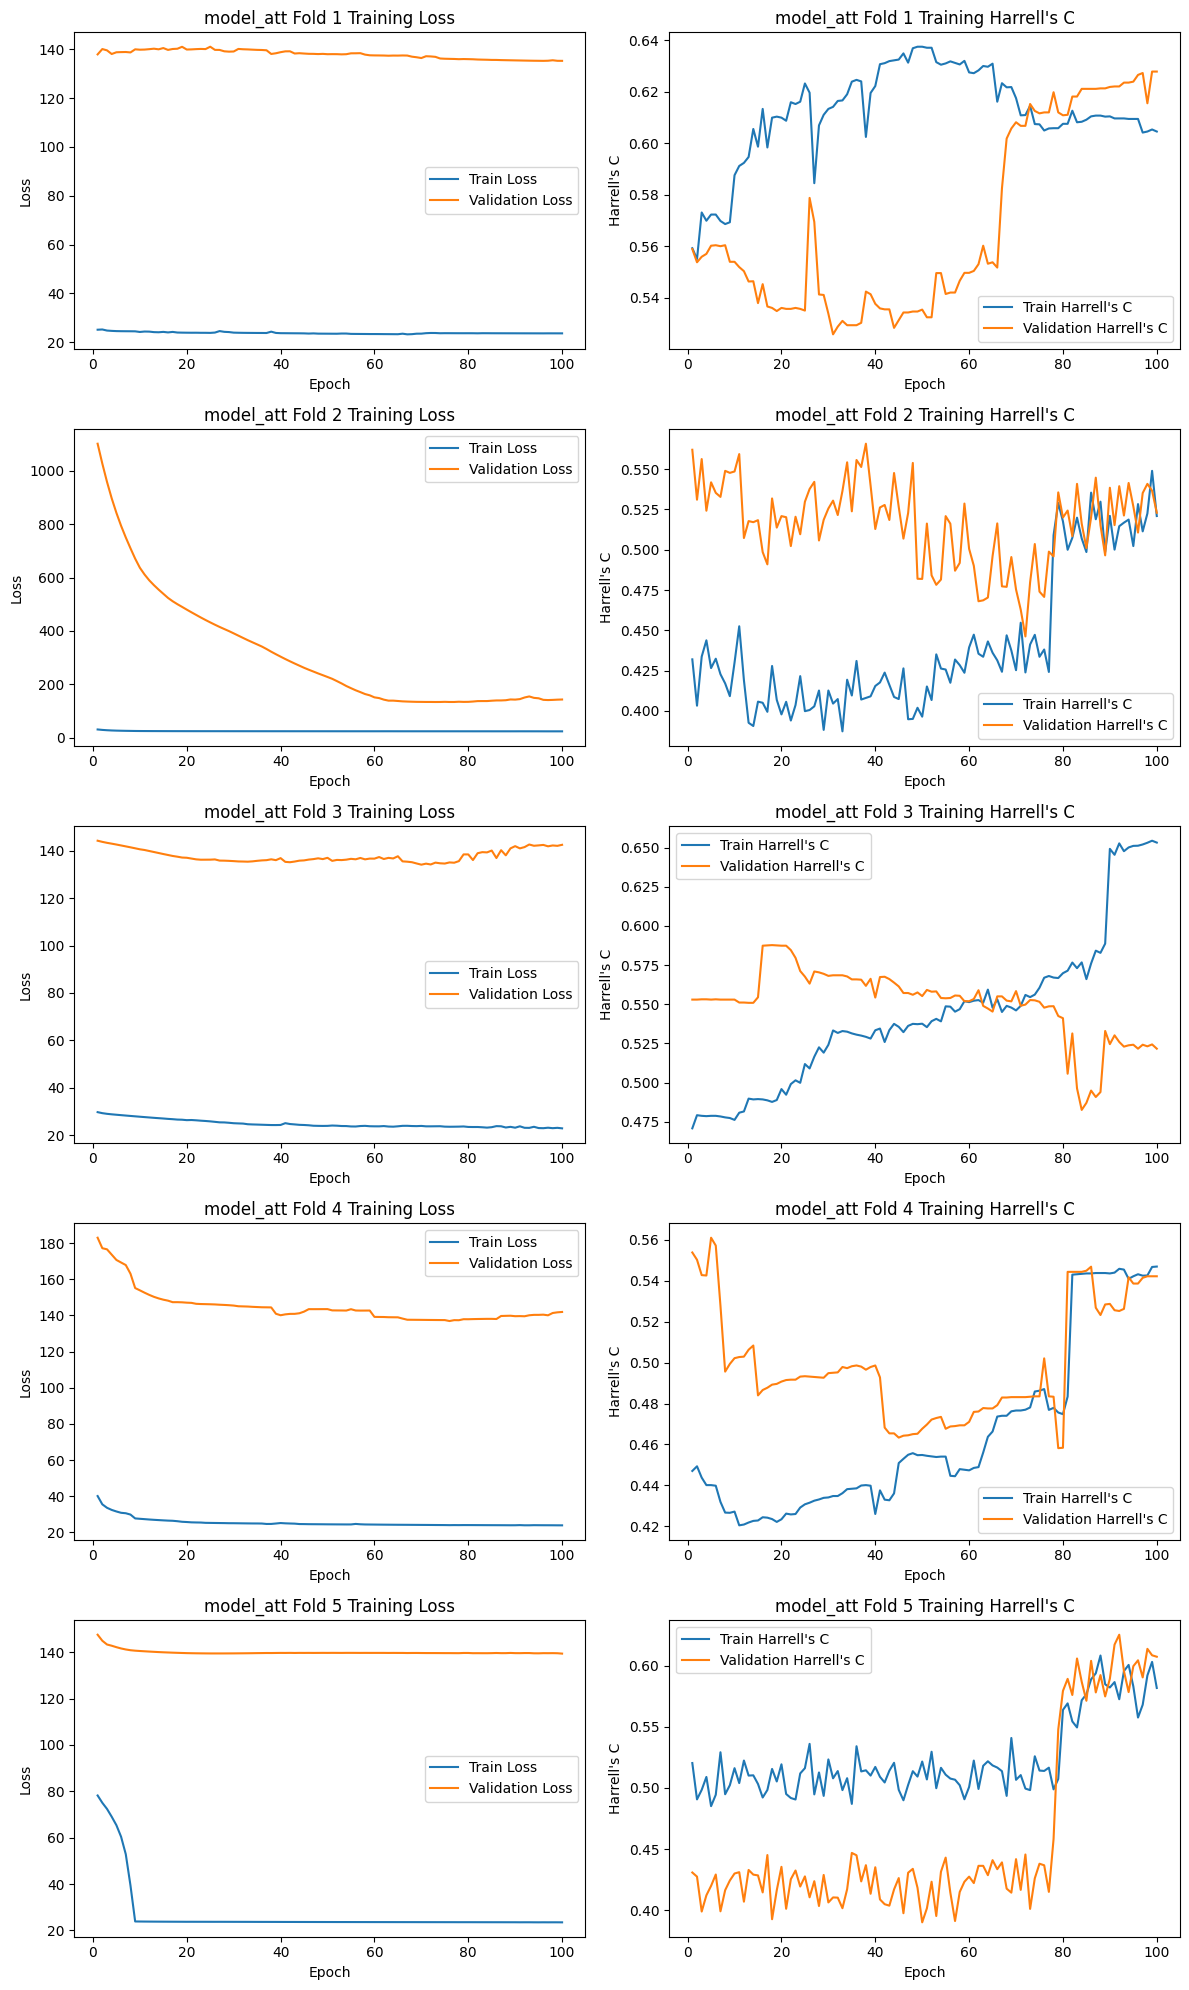

NoEvent-Bin3    412
NoEvent-Bin2    333
NoEvent-Bin4    272
NoEvent-Bin5    107
NoEvent-Bin1     65
Event-Bin2       63
Event-Bin1       45
Event-Bin3       13
Event-Bin4        6
Event-Bin5        2
Name: strata, dtype: int64

Fold 1/5
Train strata counts:
NoEvent-Bin3    329
NoEvent-Bin2    267
NoEvent-Bin4    218
NoEvent-Bin5     85
NoEvent-Bin1     52
Event-Bin2       51
Event-Bin1       36
Event-Bin3       10
Event-Bin4        4
Event-Bin5        2
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    83
NoEvent-Bin2    66
NoEvent-Bin4    54
NoEvent-Bin5    22
NoEvent-Bin1    13
Event-Bin2      12
Event-Bin1       9
Event-Bin3       3
Event-Bin4       2
Name: strata, dtype: int64
The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (None, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Testing c-index: 0.614

Fold 2/5
Train strata counts:
NoEvent-Bin3    329
NoEvent-Bin2    267
NoEvent-Bin4    217
NoEvent-Bin5     85
NoEvent-Bin1     52
Event-Bin2       51
Event-Bin1       36
Event-Bin3       11
Event-Bin4        5
Event-Bin5        1
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    83
NoEvent-Bin2    66
NoEvent-Bin4    55
NoEvent-Bin5    22
NoEvent-Bin1    13
Event-Bin2      12
Event-Bin1       9
Event-Bin3       2
Event-Bin5       1
Event-Bin4       1
Name: strata, dtype: int64
The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (None, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Testing c-index: 0.438

Fold 3/5
Train strata counts:
NoEvent-Bin3    330
NoEvent-Bin2    266
NoEvent-Bin4    217
NoEvent-Bin5     86
NoEvent-Bin1     52
Event-Bin2       50
Event-Bin1       36
Event-Bin3       11
Event-Bin4        5
Event-Bin5        1
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    82
NoEvent-Bin2    67
NoEvent-Bin4    55
NoEvent-Bin5    21
NoEvent-Bin1    13
Event-Bin2      13
Event-Bin1       9
Event-Bin3       2
Event-Bin4       1
Event-Bin5       1
Name: strata, dtype: int64
The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (None, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Testing c-index: 0.460

Fold 4/5
Train strata counts:
NoEvent-Bin3    330
NoEvent-Bin2    266
NoEvent-Bin4    218
NoEvent-Bin5     86
NoEvent-Bin1     52
Event-Bin2       50
Event-Bin1       36
Event-Bin3       10
Event-Bin4        5
Event-Bin5        2
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    82
NoEvent-Bin2    67
NoEvent-Bin4    54
NoEvent-Bin5    21
Event-Bin2      13
NoEvent-Bin1    13
Event-Bin1       9
Event-Bin3       3
Event-Bin4       1
Name: strata, dtype: int64
The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (None, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Testing c-index: 0.555

Fold 5/5
Train strata counts:
NoEvent-Bin3    330
NoEvent-Bin2    266
NoEvent-Bin4    218
NoEvent-Bin5     86
NoEvent-Bin1     52
Event-Bin2       50
Event-Bin1       36
Event-Bin3       10
Event-Bin4        5
Event-Bin5        2
Name: strata, dtype: int64
Validation strata counts:
NoEvent-Bin3    82
NoEvent-Bin2    67
NoEvent-Bin4    54
NoEvent-Bin5    21
NoEvent-Bin1    13
Event-Bin2      13
Event-Bin1       9
Event-Bin3       3
Event-Bin4       1
Name: strata, dtype: int64
The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (None, 1)
Checking train set batches:
Number of valid batches: 16
Number of invalid batches: 0
Number of valid subjects: 1024
Number of invalid subjects: 0
Preparing validation set:


/opt/anaconda3/envs/mil/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/cox/cond/gradients/cox/cond/RaggedTile/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Testing c-index: 0.300


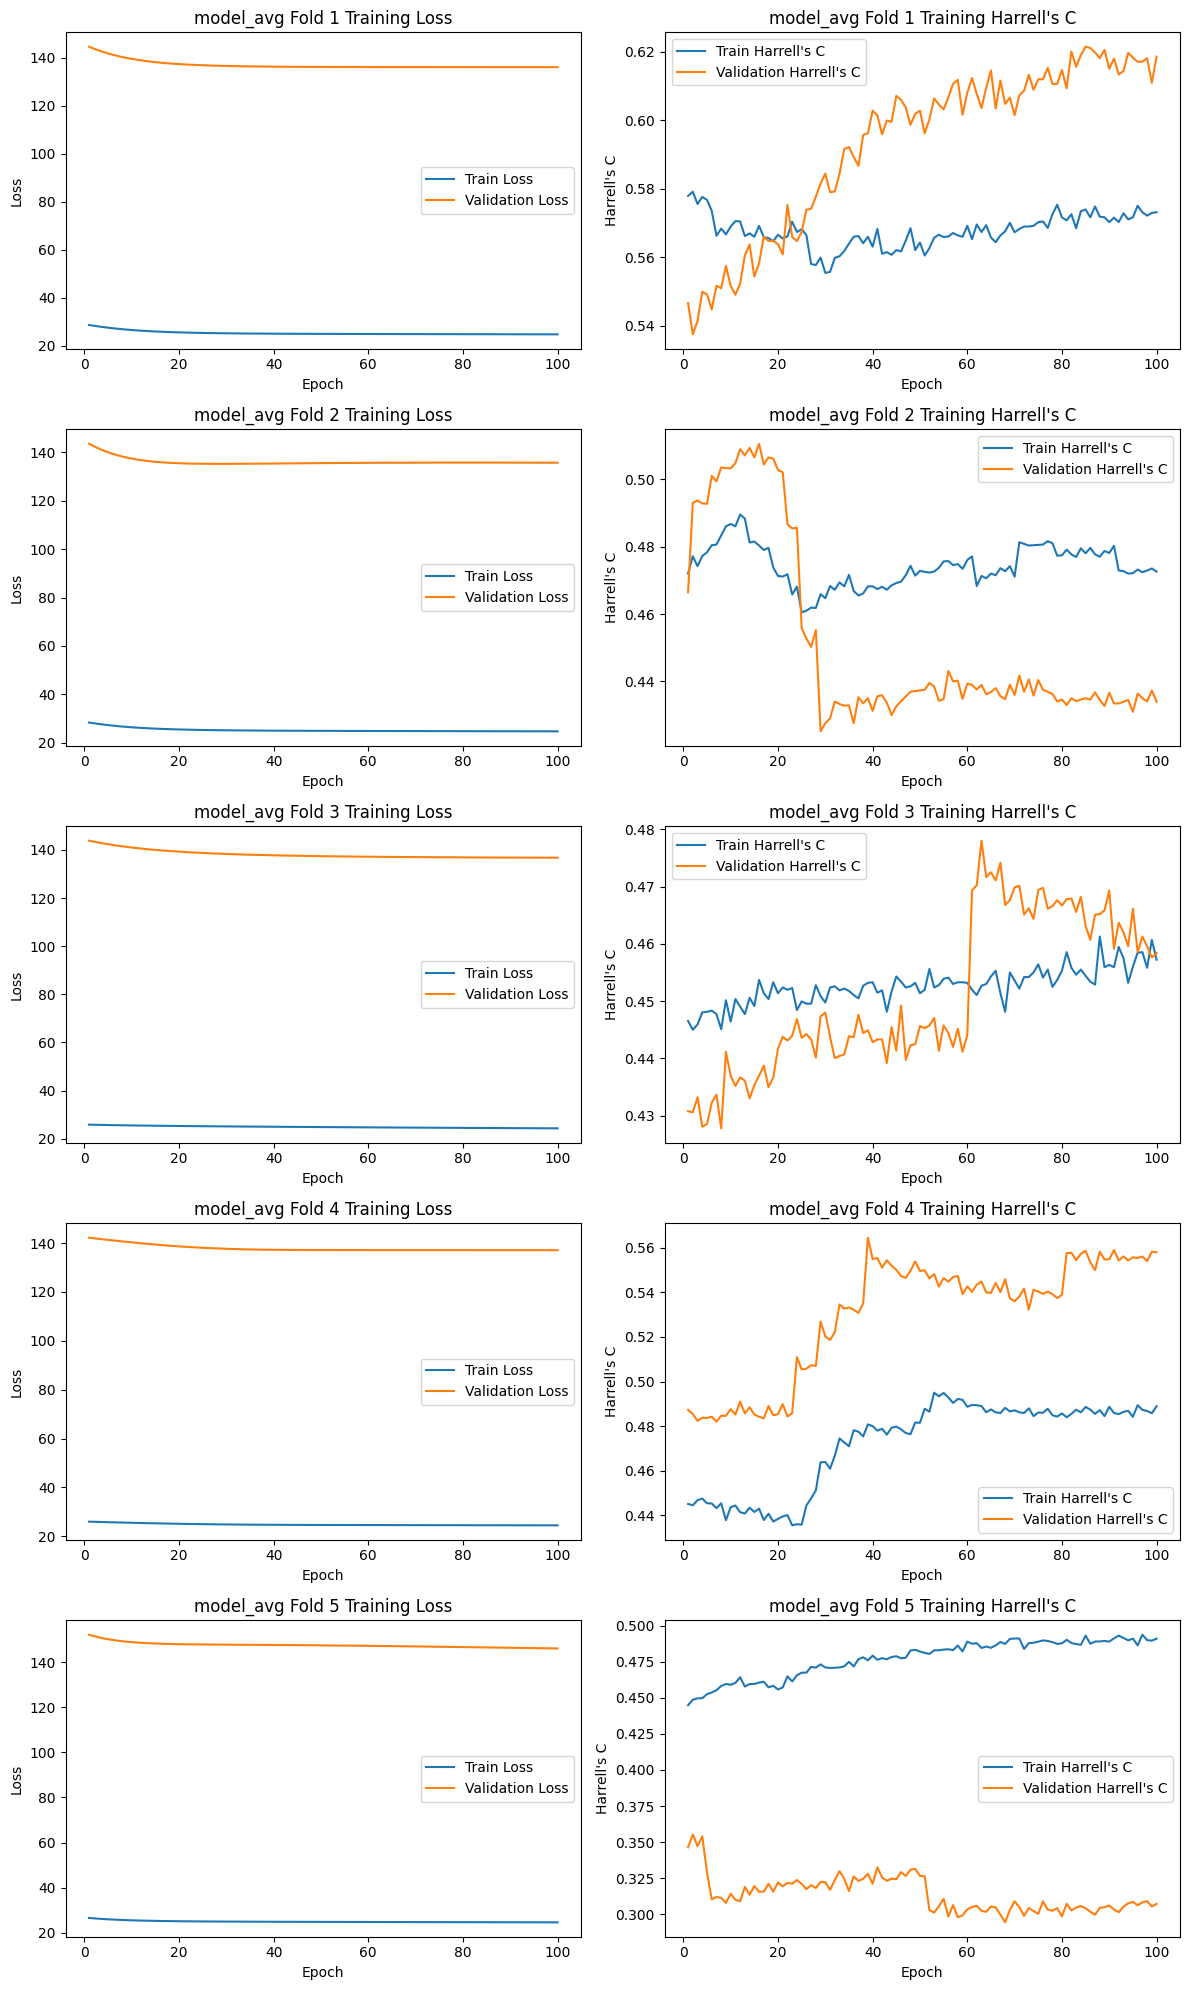

In [10]:
# histories = perform_k_fold_cross_validation(data, labels, globals, batch_size=batch_size, n_splits=5, model_name='model_att_NAM')
# plot_combined_training_metrics(histories, model_name='model_att_NAM', n_splits=5)

histories = perform_k_fold_cross_validation(data, labels, globals, batch_size=batch_size, n_splits=5, model_name='model_att')
plot_combined_training_metrics(histories, model_name='model_att', n_splits=5)

histories = perform_k_fold_cross_validation(data, labels, globals, batch_size=batch_size, n_splits=5, model_name='model_avg')
plot_combined_training_metrics(histories, model_name='model_avg', n_splits=5)


In [11]:
model = build_model_att(49, 3)

# Print the summary of the model
print(model.summary())


The input shape of model is: [(None, None, 49), (None, 3)]
The output shape of model is: (1, 1)
Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, None, 49)]   0           []                               
                                                                                                  
 dense_20 (Dense)               (None, None, 49)     2450        ['input_41[0][0]']               
                                                                                                  
 dense_21 (Dense)               (None, None, 49)     2450        ['dense_20[0][0]']               
                                                                                                  
 att (Dense)                    (None, None, 1)      50          ['dense_21[0][0]']           